# Design the bound states, sampling backbones for looping while maintaining sequence realism

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_shifties
running on node: dig68


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### One-state design the helix-bound states

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "00_design_bound_states"
design_list_file = os.path.join(
    os.getcwd(), "scaffolds/02_make_bound_states/non_junctions.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.design.one_state_design_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="3G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

### Collect scorefiles of the designed bound states and concatenate

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "00_design_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

  0%|          | 0/89278 [00:00<?, ?it/s]

### Setup for plotting

In [5]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [6]:
from crispy_shifty.protocols.design import beta_nov16_terms

scores_df = scores_df[
    [term for term in scores_df.columns if term not in beta_nov16_terms]
]
print(len(scores_df))
scores_df.columns

89278


Index(['bb_clash', 'best_average_DAN_plddts', 'best_average_plddts',
       'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent',
       'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'docked_helix',
       'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent',
       'holes_core_parent', 'loop_dist', 'mismatch_probability_parent',
       'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb',
       'pivot_helix', 'pre_break_helix', 'sap_parent', 'sc_AcB', 'sc_AnAc',
       'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type', 'score',
       'score_per_res', 'score_per_res_parent', 'shift', 'ss_sc', 'state',
       'time', 'topo', 'total_score', 'trimmed_length'],
      dtype='object')

### Convert some dtypes

In [7]:
scores_df["time"] = scores_df.time.astype(float) / 60
scores_df["bb_clash"] = scores_df.bb_clash.astype(float)
scores_df["trimmed_length"] = scores_df.trimmed_length.astype(int)

### Check for the relationship between time of run and length of parent

2it [00:00,  8.02it/s]


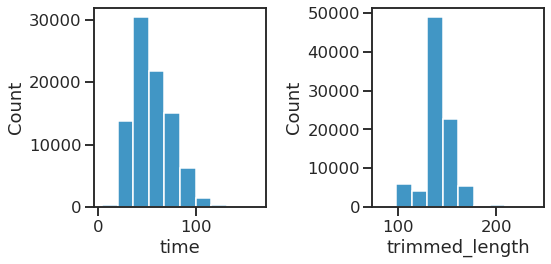

In [8]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = ["time", "trimmed_length"]

the_fig = histplot_df(
    df=scores_df,
    cols=cols,
    bins=10,
)

plt.savefig(os.path.join(output_path, "time_vs_length.png"))

<Figure size 576x576 with 0 Axes>

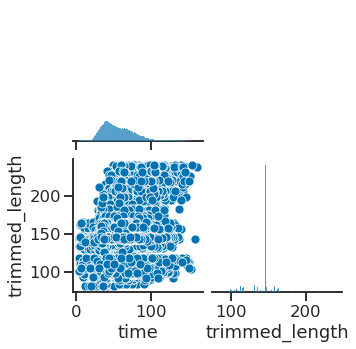

In [9]:
the_fig = pairplot_df(
    df=scores_df,
    cols=cols,
)

plt.savefig(os.path.join(output_path, "time_vs_length_paired.png"))

### Check for the relationship between time of run and `bb_clash` of input state

<Figure size 576x576 with 0 Axes>

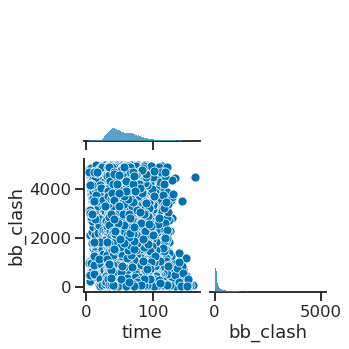

In [10]:
cols = ["time", "bb_clash"]

the_fig = pairplot_df(
    df=scores_df,
    cols=cols,
)

plt.savefig(os.path.join(output_path, "time_vs_bb_clash_paired.png"))

### Check the `ContactMolecularSurface` and `ShapeComplementarity`
Anything with `sc_*`< 0 doesn't have an interface at that site

88777


9it [00:01,  8.40it/s]


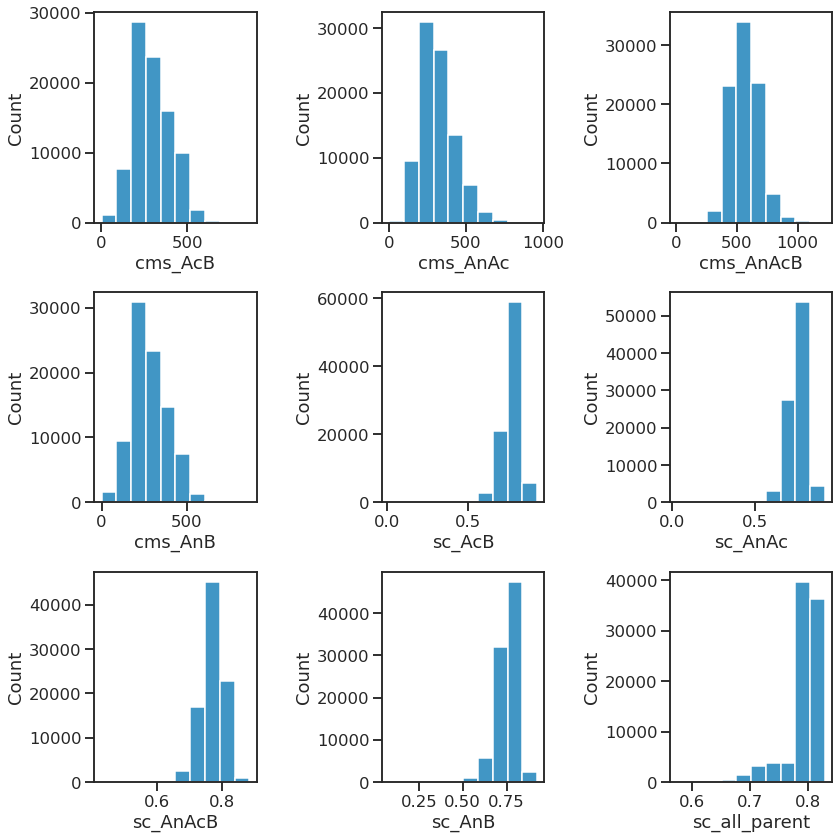

In [11]:
cols = [col for col in scores_df.columns if "cms_" in col or "sc_" in col]
for col in cols:
    scores_df[col] = scores_df[col].astype(float)

filt_df = scores_df
for col in cols:
    filt_df = filt_df[filt_df[col] > 0]
print(len(filt_df))
the_fig = histplot_df(df=filt_df, bins=10, cols=cols)
plt.savefig(os.path.join(output_path, "cms_and_sc.png"))

<Figure size 2592x2592 with 0 Axes>

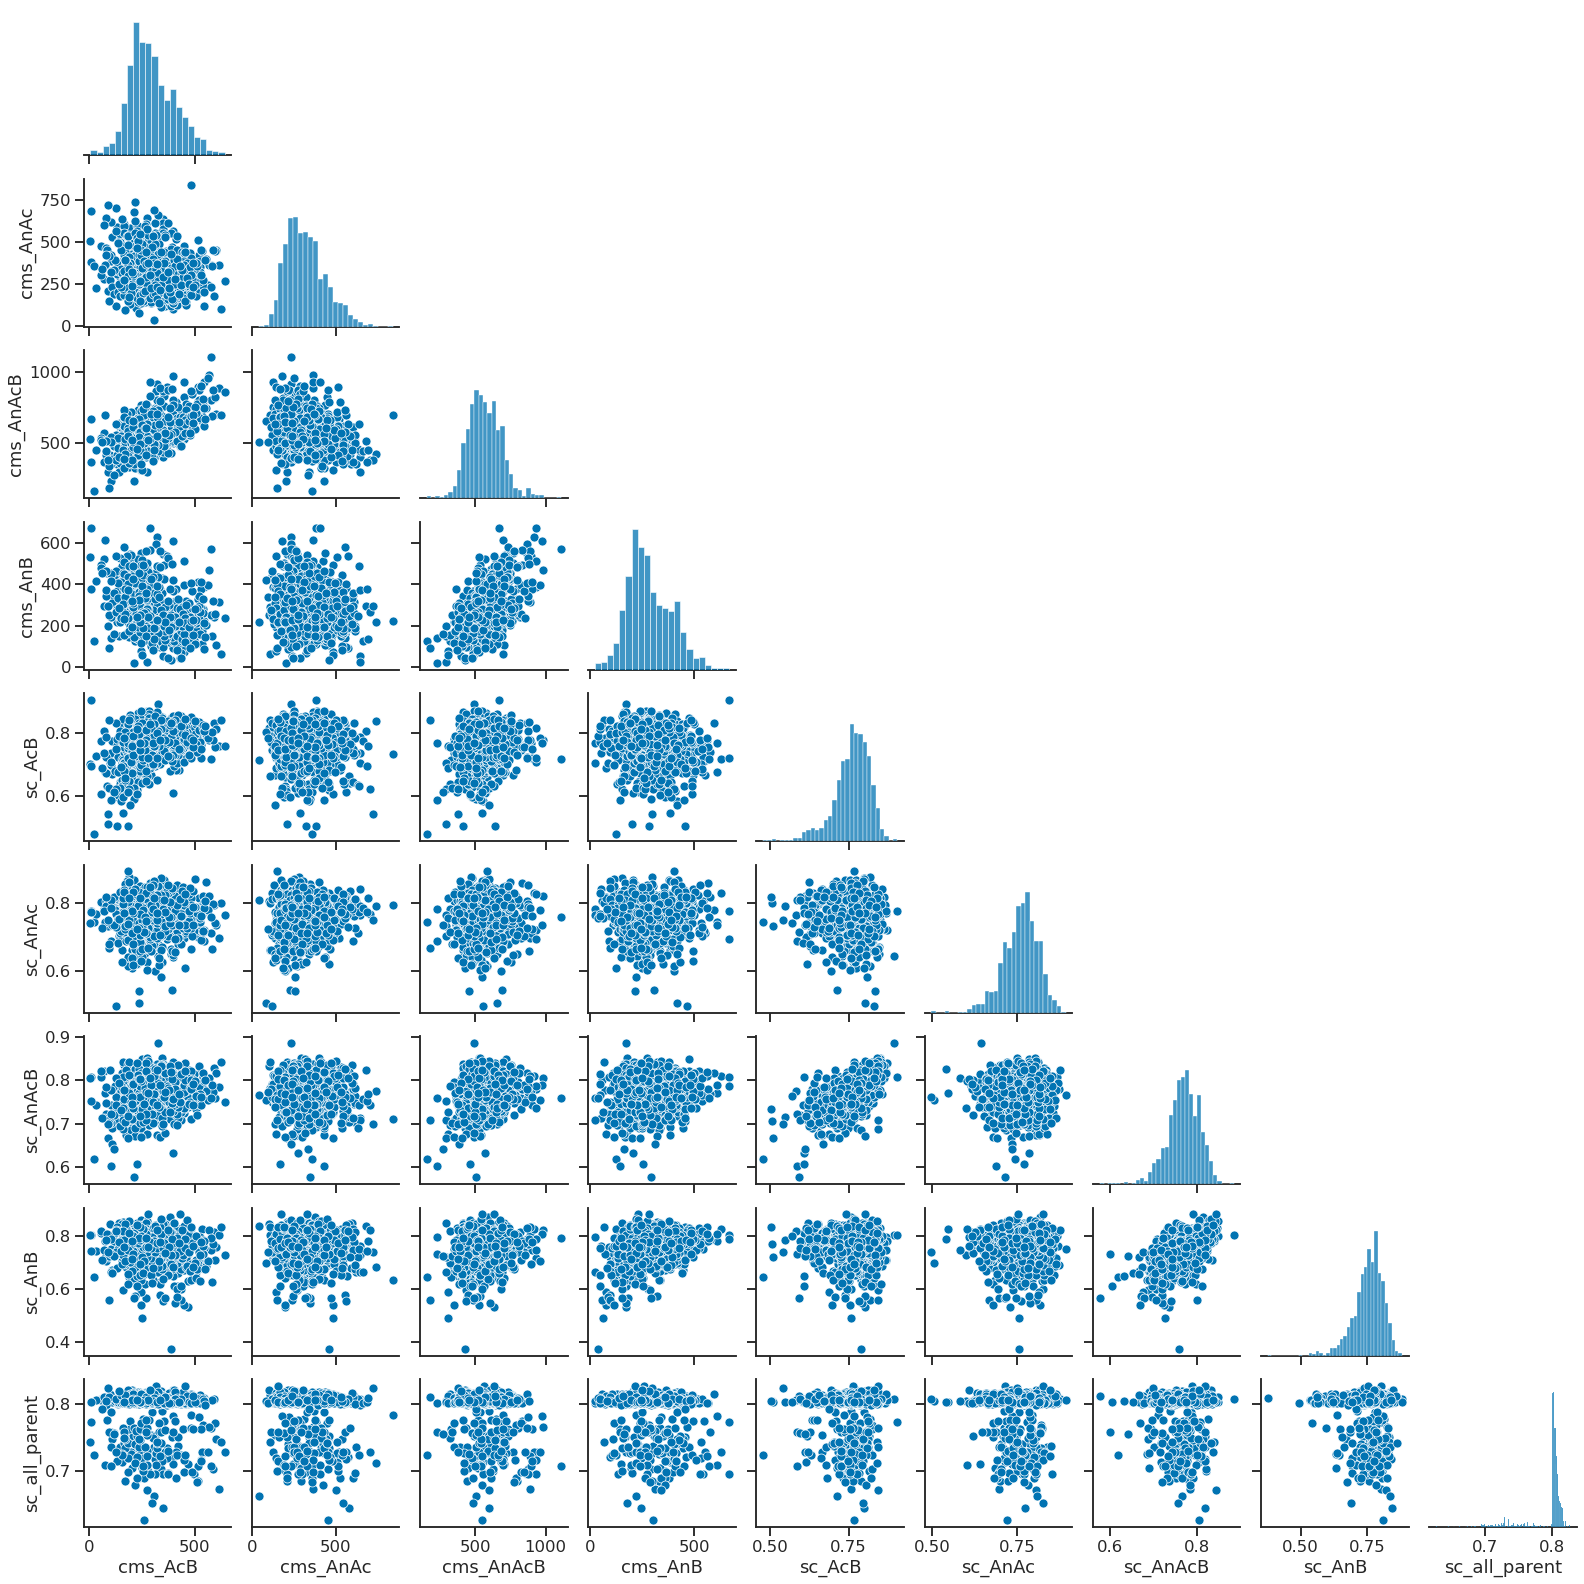

In [12]:
the_fig = pairplot_df(df=filt_df.sample(1000, random_state=0), cols=cols)
plt.savefig(os.path.join(output_path, "cms_and_sc_paired.png"))

<Figure size 2592x2592 with 0 Axes>

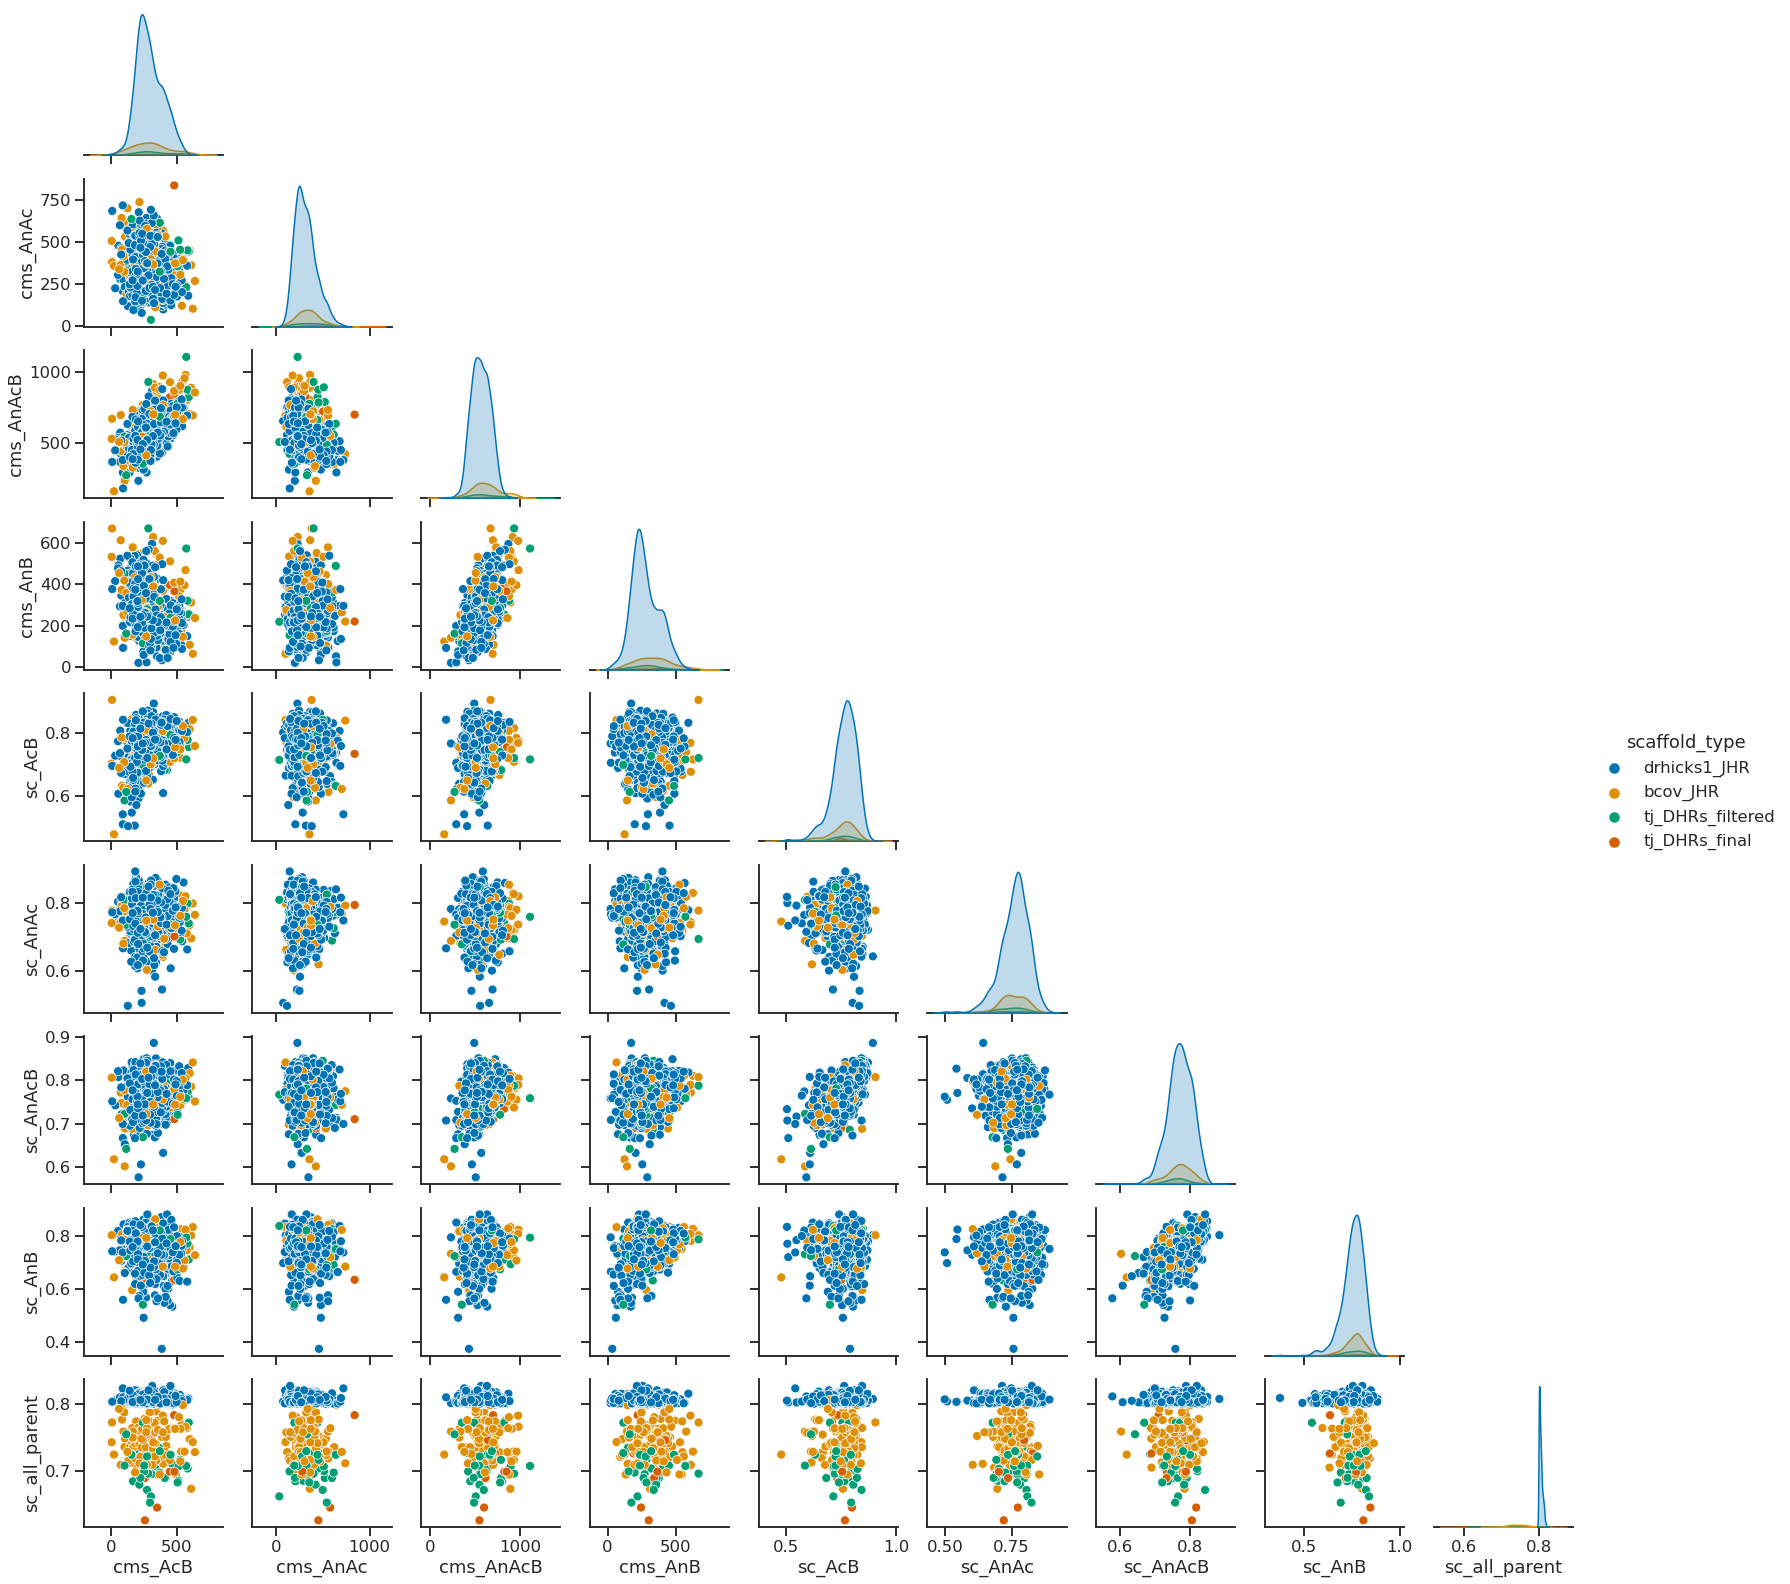

In [13]:
the_fig = pairplot_df(
    df=filt_df.sample(1000, random_state=0), cols=cols, hue="scaffold_type"
)
plt.savefig(os.path.join(output_path, "cms_and_sc_paired_by_scaffold_type.png"))

### Filter the designed states leniently
We want to discard the obviously bad stuff here

In [14]:
cols = [col for col in scores_df.columns if "cms_" in col or "sc_" in col]
final_df = scores_df
for col in cols:
    if "sc_" in col:
        threshold = 0.6  # sc cutoff
    else:
        threshold = 200  # cms cutoff
    final_df = final_df[final_df[col] > threshold]
print(len(final_df))

45933


### Save a list of outputs

In [15]:
simulation_name = "00_design_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "designed_states.list"), "w") as f:
    for path in tqdm(final_df.index):
        print(path, file=f)

  0%|          | 0/45933 [00:00<?, ?it/s]

### Prototyping blocks

test `one_state_design_bound_state`

In [ ]:
%%time 
import pyrosetta

pyrosetta.init(
#     "-corrections::beta_nov16"
)


sys.path.insert(0, "~/projects/crispy_shifty/") # TODO projects
from crispy_shifty.protocols.design import one_state_design_bound_state

t = one_state_design_bound_state(
        None,
        **{
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0000/notebooks_02_make_bound_states_ed86bcbab67e41f38322ff2f123d5b1e.pdb.bz2',
        }
)

In [ ]:
for i, tppose in enumerate(t):
    print(tppose.pose.scores)
#     tppose.pose.dump_pdb(f"{i}.pdb")

test `gen_array_tasks`

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks, test_func, wrapper_for_array_tasks

simulation_name = "test"
design_list_file = os.path.join(
    os.getcwd(), "scaffolds/02_make_bound_states/bound_states.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        # "indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.utils.io.test_func",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="4G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

In [ ]:
!sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/run.sh

test `clear_terms_from_scores`

In [ ]:
from crispy_shifty.protocols.cleaning import path_to_pose_or_ppose
from crispy_shifty.protocols.design import clear_terms_from_scores

In [ ]:
tpose = next(path_to_pose_or_ppose(scores_df.index[0], True, False))
d1 = dict(tpose.scores)
clear_terms_from_scores(tpose)
d2 = dict(tpose.scores)